### EXPLORATION 

In [1]:
WAVELET_TYPE = 'db4' #db4 is smoother than db1
LEVEL = 4 #3 

In [ ]:
import os
import glob
import random
import numpy as np
import pandas as pd
import pywt
from imageio import imread
from scipy import sparse
from tqdm import tqdm
from PIL import Image


WAVELET_TYPE = WAVELET_TYPE #db4 is smoother than db1
LEVEL = LEVEL #3        
KEEP_RATIO = 0.2
IMG_SIZE = (256, 256) 
# IMP: resizing image to 256x256 for both MRI (630 x 630) and CT (512 x 512)
# def get_sparse_wavelet_vector(img_path):
#     # Grayscale ('L') conversion
#     # This handles both the 1-channel PNGs (CT) and 3-channel JPGs (MRI)
#     # automatically, converting them to a standard 2D (H, W) array.
#     img = Image.open(img_path).convert('L').resize(IMG_SIZE)
#     img_arr = np.array(img)
#     coeffs = pywt.wavedec2(img_arr, wavelet=WAVELET_TYPE, level=LEVEL)
#     coeff_arr, _ = pywt.coeffs_to_array(coeffs)
    
#     flat_coeffs = coeff_arr.reshape(-1)
#     threshold_idx = int(np.floor((1 - KEEP_RATIO) * len(flat_coeffs)))
    
#     sorted_abs = np.sort(np.abs(flat_coeffs))
#     threshold = sorted_abs[threshold_idx]
#     flat_coeffs[np.abs(flat_coeffs) <= threshold] = 0

#     return sparse.csr_matrix(flat_coeffs)


import numpy as np
import pywt
from scipy import sparse
from PIL import Image

def _normalize_img(img_arr: np.ndarray, norm: str = "robust") -> np.ndarray:
    x = img_arr.astype(np.float32)
    stats = {}
    
    if norm == "none":
        return x, stats 

    if norm == "zscore":
        mu = x.mean()
        sd = x.std() + 1e-8
        stats = {'mu': mu, 'std': sd}
        return (x - mu) / sd, stats 

    if norm == "robust":
        med = np.median(x)
        q1, q3 = np.percentile(x, [25, 75])
        iqr = (q3 - q1) + 1e-8
        stats = {'median': med, 'iqr': iqr}
        return (x - med) / iqr, stats 

    if norm == "clip01":
        lo, hi = np.percentile(x, [1, 99])
        x = np.clip(x, lo, hi)
        stats = {'min': lo, 'max': hi}
        x = (x - lo) / (hi - lo + 1e-8)
        return x, stats 

def get_sparse_wavelet_vector(
    img_path,
    norm: str = "robust",
    band: str = "all",            
    keep_ratio: float = KEEP_RATIO,
    wavelet: str = WAVELET_TYPE,
    level: int = LEVEL,
    img_size=IMG_SIZE,
    threshold_mode: str = "per_image"  # keep for future extensions
):
    # Load → grayscale → resize
    img = Image.open(img_path).convert("L").resize(img_size)
    img_arr = np.array(img)

    img_arr, stats = _normalize_img(img_arr, norm=norm)
    coeffs = pywt.wavedec2(img_arr, wavelet=wavelet, level=level)

    # Optional band ablation
    # coeffs format: [cA_n, (cH_n, cV_n, cD_n), ..., (cH_1, cV_1, cD_1)]
    if band == "approx_only":
        cA = coeffs[0]
        zeros_details = [tuple(np.zeros_like(b) for b in detail) for detail in coeffs[1:]]
        coeffs = [cA] + zeros_details
    elif band == "detail_only":
        cA = np.zeros_like(coeffs[0])
        coeffs = [cA] + coeffs[1:]
    elif band != "all":
        raise ValueError(f"Unknown band='{band}'")

    coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    flat = coeff_arr.reshape(-1).astype(np.float32)

    if keep_ratio < 1.0:
        k = int(np.floor((1 - keep_ratio) * flat.size))
        # guard for extreme keep_ratio
        k = np.clip(k, 0, flat.size - 1)

        thresh = np.partition(np.abs(flat), k)[k]
        flat[np.abs(flat) <= thresh] = 0.0

    return sparse.csr_matrix(flat), coeff_slices, stats 

import os 
HOME_DIR = f'/home/shreyamm/Desktop/UPenn/projects/udt/'
DATA_DIR = os.path.join(HOME_DIR, 'data/ct2mri/images')
files_A = glob.glob(f'{DATA_DIR}/trainA/*.png')
files_B = glob.glob(f'{DATA_DIR}/trainB/*.jpg')

dataset_list = []
for f in files_A:
    dataset_list.append({'path': f, 'domain': 'A', 'label': 0})
for f in files_B:
    dataset_list.append({'path': f, 'domain': 'B', 'label': 1})

random.shuffle(dataset_list)
print(f"Processing {len(dataset_list)} images...")

data_rows = []
meta_rows = []

for item in tqdm(dataset_list):
    vec, _, stats = get_sparse_wavelet_vector(item['path'], norm='zscore')
    data_rows.append(vec)
    item.update(stats)
    meta_rows.append(item)

W = sparse.vstack(data_rows)
df_meta = pd.DataFrame(meta_rows)

print(f"Matrix W constructed. Shape: {W.shape}")
print(f"Sparsity: {1.0 - (W.nnz / (W.shape[0] * W.shape[1])):.4f}")

Processing 3486 images...


100%|██████████| 3486/3486 [00:10<00:00, 333.84it/s]


Matrix W constructed. Shape: (3486, 79524)
Sparsity: 0.8001


In [16]:
from scipy import sparse
import os 
HOME_DIR = f'/home/shreyamm/Desktop/UPenn/projects/udt/'
EXP_DIR = os.path.join(HOME_DIR, 'experiments/ct2mri')
sparse.save_npz(f'{EXP_DIR}/data_matrix_W.npz', W)
# which row corresponds to which image/domain
df_meta.to_csv(f'{EXP_DIR}/metadata_W.csv', index=False)


In [2]:
from scipy import sparse
import pandas as pd
import os 
HOME_DIR = f'/home/shreyamm/Desktop/UPenn/projects/udt/'
EXP_DIR = os.path.join(HOME_DIR, 'experiments/ct2mri')
W = sparse.load_npz(f'{EXP_DIR}/data_matrix_W.npz')
df_meta = pd.read_csv(f'{EXP_DIR}/metadata_W.csv')

print(f"Loaded W: {W.shape}")
print(f"Loaded Meta: {len(df_meta)} rows")

Loaded W: (3486, 79524)
Loaded Meta: 3486 rows


In [3]:
def reconstruct_image_with_denorm(sparse_row, slices, dest_shape, wavelet_shape, mu, std, wavelet=WAVELET_TYPE):
    """
    Reconstructs image from sparse vector and denormalizes it using stored mu/std.
    """
    dense_vec = sparse_row.toarray().flatten()
    coeffs_reshaped = dense_vec.reshape(wavelet_shape)
    coeffs_rebuilt = pywt.array_to_coeffs(coeffs_reshaped, slices, output_format='wavedec2')
    recon_norm = pywt.waverec2(coeffs_rebuilt, wavelet=wavelet)

    recon = (recon_norm * std) + mu
    recon = recon[:dest_shape[0], :dest_shape[1]]
    return np.clip(recon, 0, 255).astype('uint8')

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pywt
from PIL import Image

IMG_SIZE = (256, 256)
WAVELET_TYPE = WAVELET_TYPE
LEVEL = LEVEL #3, 4

# Compute Shapes using Dummy Image (Same as before) ---
# Note: np.zeros(IMG_SIZE) creates a 2D array (H, W), which is perfect for grayscale.
dummy_img = np.zeros(IMG_SIZE)
coeffs = pywt.wavedec2(dummy_img, wavelet=WAVELET_TYPE, level=LEVEL)
arr, coeff_slices = pywt.coeffs_to_array(coeffs)
coeff_shape = arr.shape  

def reconstruct_image_from_vector(sparse_row, slices, dest_shape, wavelet_shape):
    """
    Reconstructs a Grayscale image from a sparse flattened wavelet vector.
    """
    dense_vec = sparse_row.toarray().flatten()
    coeffs_reshaped = dense_vec.reshape(wavelet_shape)
    coeffs_rebuilt = pywt.array_to_coeffs(coeffs_reshaped, slices, output_format='wavedec2')
    recon = pywt.waverec2(coeffs_rebuilt, wavelet=WAVELET_TYPE)
    recon = recon[:dest_shape[0], :dest_shape[1]]
    return np.clip(recon, 0, 255).astype('uint8')

indices_to_check = np.random.choice(len(df_meta), 4, replace=False)

plt.figure(figsize=(12, 10))

for i, idx in enumerate(indices_to_check):
    row_data = df_meta.iloc[idx]
    mu_val = row_data['mu']
    std_val = row_data['std']
    original_path = row_data['path']
    domain = row_data['domain']
    img_orig = Image.open(original_path).convert('L').resize(IMG_SIZE)

    sparse_vector = W[idx]
    img_recon = reconstruct_image_with_denorm(sparse_vector, coeff_slices, IMG_SIZE, coeff_shape,
                                              mu_val, std_val)
    #img_recon = reconstruct_image_from_vector(sparse_vector, coeff_slices, IMG_SIZE, coeff_shape)
    # img_recon = (img_recon * std_val) + mu_val
    plt.subplot(4, 2, 2*i + 1)
    plt.imshow(img_orig, cmap='gray') 
    plt.title(f"Original (Idx: {idx}, Domain: {domain})")
    plt.axis('off')
    
    # Plotting Reconstructed
    plt.subplot(4, 2, 2*i + 2)
    plt.imshow(img_recon, cmap='gray') 
    
    sparsity = 1.0 - (sparse_vector.nnz / sparse_vector.shape[1])
    plt.title(f"Reconstructed (Sparsity: {sparsity:.1%})")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [22]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np

N_COMPONENTS = 256  # Number of singular values/vectors to compute
RANDOM_STATE = 42

print(f"Starting SVD with {N_COMPONENTS} components...")
svd = TruncatedSVD(n_components=N_COMPONENTS, random_state=RANDOM_STATE)
# Z is new latent representation: shape (N_samples, N_components)
Z = svd.fit_transform(W)

print(f"SVD Complete.")
print(f"Latent shape Z: {Z.shape}")

Starting SVD with 256 components...


SVD Complete.
Latent shape Z: (3486, 256)


In [23]:
import numpy as np
import joblib 

np.save(f'{EXP_DIR}/Z_latent.npy', Z)
joblib.dump(svd, f'{EXP_DIR}/svd_model.joblib')

print("Saved Z and SVD model successfully.")

Saved Z and SVD model successfully.


In [5]:
import joblib 
import numpy as np
Z = np.load(f'{EXP_DIR}/Z_latent.npy')
svd = joblib.load(f'{EXP_DIR}/svd_model.joblib')

Total Variance Explained: 83.70%


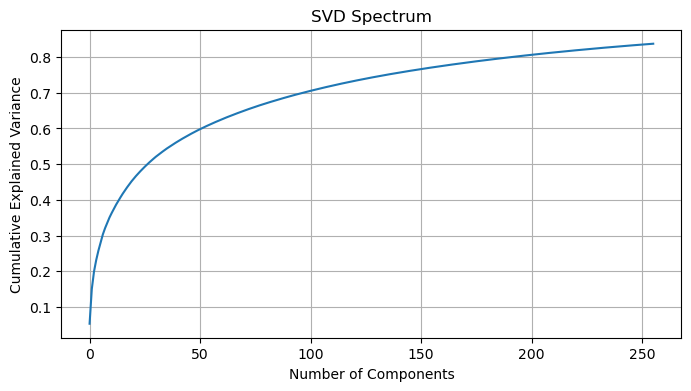

In [6]:
explained_var = svd.explained_variance_ratio_.sum()
print(f"Total Variance Explained: {explained_var:.2%}")

plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('SVD Spectrum')
plt.grid(True)
plt.show()


C          | Train Acc  | Val Acc    | Active Feats (domain-varying) | Inactive (domain-invariant)
--------------------------------------------------------------------------------
0.001      | 0.504      | 0.481      | 0                    | 256
0.01       | 0.831      | 0.804      | 22                   | 234


0.1        | 0.963      | 0.936      | 157                  | 99
1.0        | 0.989      | 0.951      | 227                  | 29
10.0       | 0.998      | 0.948      | 252                  | 4

Selection Complete.
Content Dimensions (Invariant): 237
Style Dimensions (Domain Specific): 19


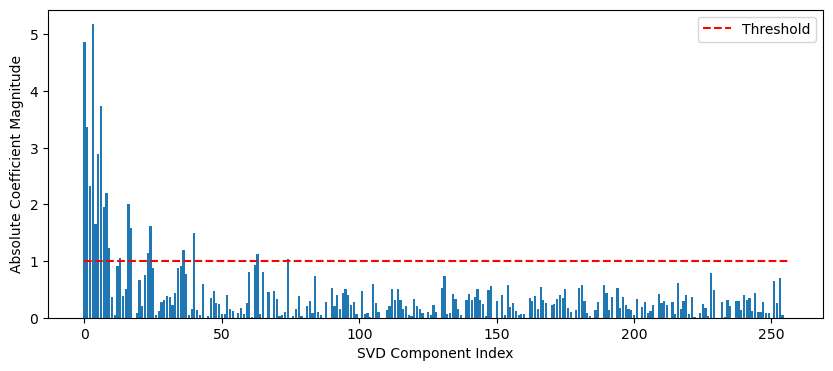

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

y = np.array([item['label'] for item in df_meta.to_dict('records')])
X_train, X_val, y_train, y_val = train_test_split(Z, y, test_size=0.2, random_state=42)

# C = inverse of regularization strength 
# Small C = Fewer active features (more sparsity)
# trying a few values to find the balance
c_values = [0.001, 0.01, 0.1, 1.0, 10.0]

best_model = None
best_acc = 0

print(f"{'C':<10} | {'Train Acc':<10} | {'Val Acc':<10} | {'Active Feats (domain-varying)':<20} | {'Inactive (domain-invariant)'}")
print("-" * 80)

for C in c_values:
    model = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty="l1", solver="saga", C=C, max_iter=5000, n_jobs=-1)
    )
    model.fit(X_train, y_train)
    # clf = LogisticRegression(penalty='l1', C=C, solver='liblinear', random_state=42)
    # using l1 penalty to ensure sparsity
    # clf.fit(X_train, y_train)
    
    # train_acc = clf.score(X_train, y_train)
    # val_acc = clf.score(X_val, y_val)
    # coefs = clf.coef_.flatten()

    train_acc = model.score(X_train, y_train)
    val_acc = model.score(X_val, y_val)
    coefs = model.named_steps['logisticregression'].coef_.flatten()
    
    n_active = np.sum(np.abs(coefs) > 1e-5)
    n_inactive = len(coefs) - n_active
    
    print(f"{C:<10} | {train_acc:.3f}      | {val_acc:.3f}      | {n_active:<20} | {n_inactive}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model = model

beta = best_model.named_steps['logisticregression'].coef_.flatten()

threshold = 1
active_mask = np.abs(beta) > threshold   # Domain-Variant Subspace
inactive_mask = ~active_mask             # Domain Invariant Subspace

print("\nSelection Complete.")
print(f"Content Dimensions (Invariant): {np.sum(inactive_mask)}")
print(f"Style Dimensions (Domain Specific): {np.sum(active_mask)}")

plt.figure(figsize=(10, 4))
plt.bar(range(len(beta)), np.abs(beta))
plt.xlabel('SVD Component Index')
plt.ylabel('Absolute Coefficient Magnitude')
# plt.title(f'Feature Importance (Beta) for Domain Classification (C={best_model.C})')
plt.hlines(threshold, 0, len(beta), colors='r', linestyles='dashed', label='Threshold')
plt.legend()
plt.show()

In [8]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def permutation_importance_cv(
    Z, y,
    C=0.1,
    n_splits=5,
    n_repeats=10,
    random_state=42
):
    rng = np.random.default_rng(random_state)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    d = Z.shape[1]
    importances = np.zeros(d, dtype=float)
    importances_sq = np.zeros(d, dtype=float)
    n_total = 0

    for train_idx, val_idx in skf.split(Z, y):
        X_tr, X_va = Z[train_idx], Z[val_idx]
        y_tr, y_va = y[train_idx], y[val_idx]

        model = make_pipeline(
            StandardScaler(),
            LogisticRegression(penalty="l1", solver="saga", C=C, max_iter=5000, n_jobs=-1)
        )
        model.fit(X_tr, y_tr)

        # baseline AUC
        p0 = model.predict_proba(X_va)[:, 1]
        auc0 = roc_auc_score(y_va, p0)

        for j in range(d):
            drops = []
            for _ in range(n_repeats):
                Xp = X_va.copy()
                Xp[:, j] = rng.permutation(Xp[:, j])
                p1 = model.predict_proba(Xp)[:, 1]
                auc1 = roc_auc_score(y_va, p1)
                drops.append(auc0 - auc1)

            drop_mean = float(np.mean(drops))
            importances[j] += drop_mean
            importances_sq[j] += drop_mean**2
            n_total += 1

    imp_mean = importances / n_splits
    imp_std = np.sqrt(np.maximum(importances_sq / n_splits - imp_mean**2, 0.0))

    return imp_mean, imp_std

y = np.array([item['label'] for item in df_meta.to_dict('records')])
imp_mean, imp_std = permutation_importance_cv(Z, y, C=0.1, n_splits=5, n_repeats=5)

rank = np.argsort(-imp_mean)
topk = rank[:30]
print(list(zip(topk, imp_mean[topk], imp_std[topk])))

active_mask = (imp_mean - 2*imp_std) > 0
inactive_mask = ~active_mask
print("Active:", active_mask.sum(), "Inactive:", inactive_mask.sum())


[(np.int64(3), np.float64(0.09565644054599332), np.float64(0.015463597898508239)), (np.int64(0), np.float64(0.07583027600985105), np.float64(0.014580737089707143)), (np.int64(1), np.float64(0.050690977283749196), np.float64(0.005168987952217539)), (np.int64(6), np.float64(0.036868191916964235), np.float64(0.008296707580906832)), (np.int64(5), np.float64(0.021386850437311245), np.float64(0.0061107756965284804)), (np.int64(2), np.float64(0.018229511733242682), np.float64(0.003361087129818582)), (np.int64(8), np.float64(0.015486967766434948), np.float64(0.0027373935399157925)), (np.int64(16), np.float64(0.011483619361409883), np.float64(0.0032711611387791642)), (np.int64(7), np.float64(0.010638791161803713), np.float64(0.00344765173866108)), (np.int64(40), np.float64(0.010551164717802871), np.float64(0.0035695101222826832)), (np.int64(4), np.float64(0.008812066450580275), np.float64(0.001759159426303512)), (np.int64(24), np.float64(0.006816387518098832), np.float64(0.0022388266582939113))

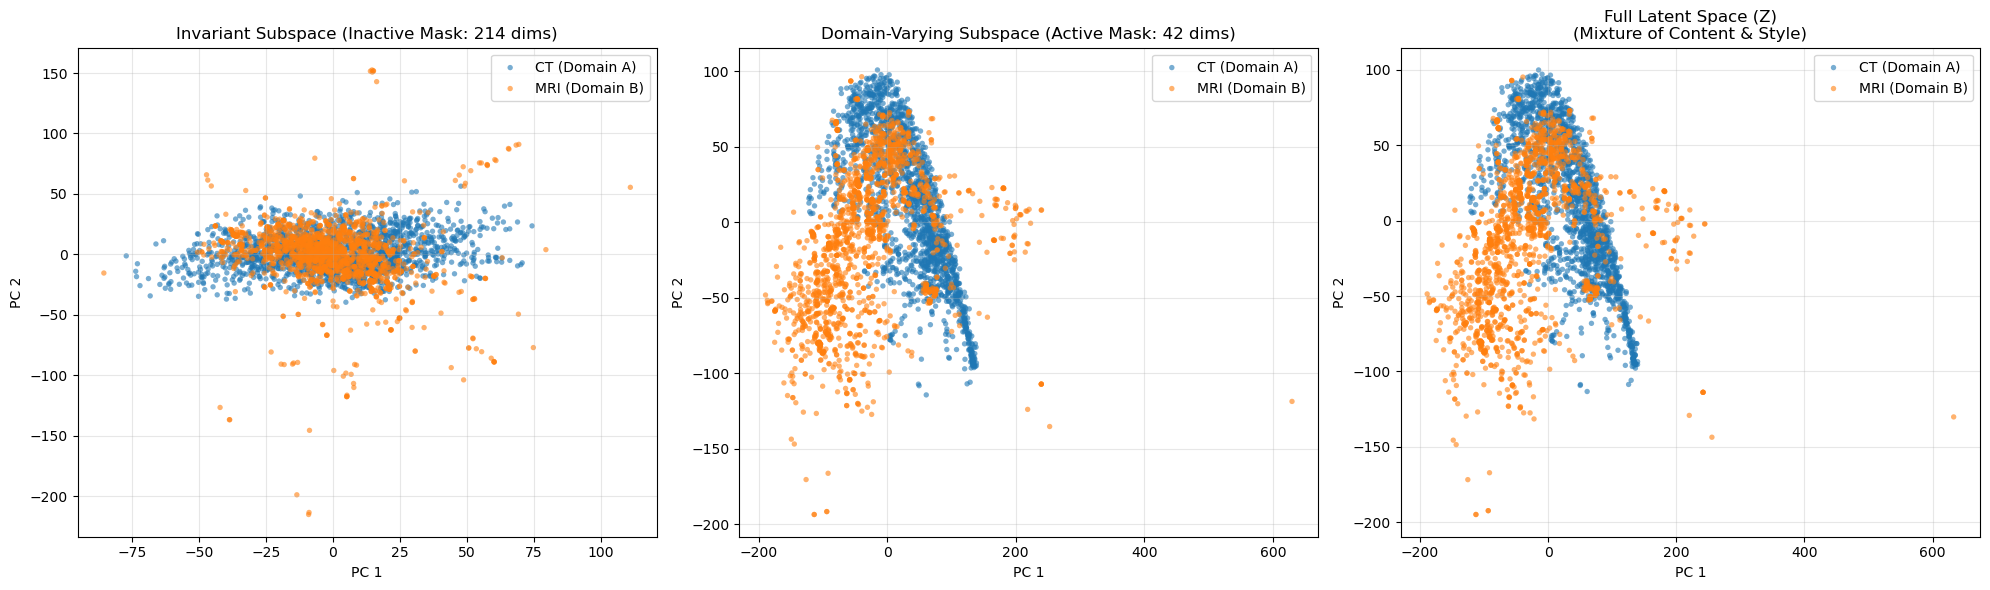

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_disentanglement(Z, y, active_mask, inactive_mask):
    """
    Plots the PCA projections of the Invariant, Variant, and Full subspaces.
    """
    Z_invariant = Z[:, inactive_mask] # Content 
    Z_variant = Z[:, active_mask]     # Style 
    
    pca_inv = PCA(n_components=2).fit_transform(Z_invariant)
    pca_var = PCA(n_components=2).fit_transform(Z_variant)
    pca_full = PCA(n_components=2).fit_transform(Z)

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    labels = ['CT (Domain A)', 'MRI (Domain B)']
    colors = ['#1f77b4', '#ff7f0e'] # Blue, Orange
    alphas = [0.6, 0.6]

    ax = axes[0]
    for label_val, name, color, alpha in zip([0, 1], labels, colors, alphas):
        idx = (y == label_val)
        ax.scatter(pca_inv[idx, 0], pca_inv[idx, 1], c=color, label=name, alpha=alpha, s=15, edgecolor='none')
    
    ax.set_title(f"Invariant Subspace (Inactive Mask: {inactive_mask.sum()} dims)", fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")

    ax = axes[1]
    for label_val, name, color, alpha in zip([0, 1], labels, colors, alphas):
        idx = (y == label_val)
        ax.scatter(pca_var[idx, 0], pca_var[idx, 1], c=color, label=name, alpha=alpha, s=15, edgecolor='none')
        
    ax.set_title(f"Domain-Varying Subspace (Active Mask: {active_mask.sum()} dims)", fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")

    ax = axes[2]
    for label_val, name, color, alpha in zip([0, 1], labels, colors, alphas):
        idx = (y == label_val)
        ax.scatter(pca_full[idx, 0], pca_full[idx, 1], c=color, label=name, alpha=alpha, s=15, edgecolor='none')
        
    ax.set_title(f"Full Latent Space (Z)\n(Mixture of Content & Style)", fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")

    plt.tight_layout()
    plt.show()

visualize_disentanglement(Z, y, active_mask, inactive_mask)
# plot 2 and 3 look identical because the SVD gives us an orthogonal
# basis. This is why when we do a full pca, the pca is identical to the
# domain varying pca since maximum varying eigendirections form the pca space

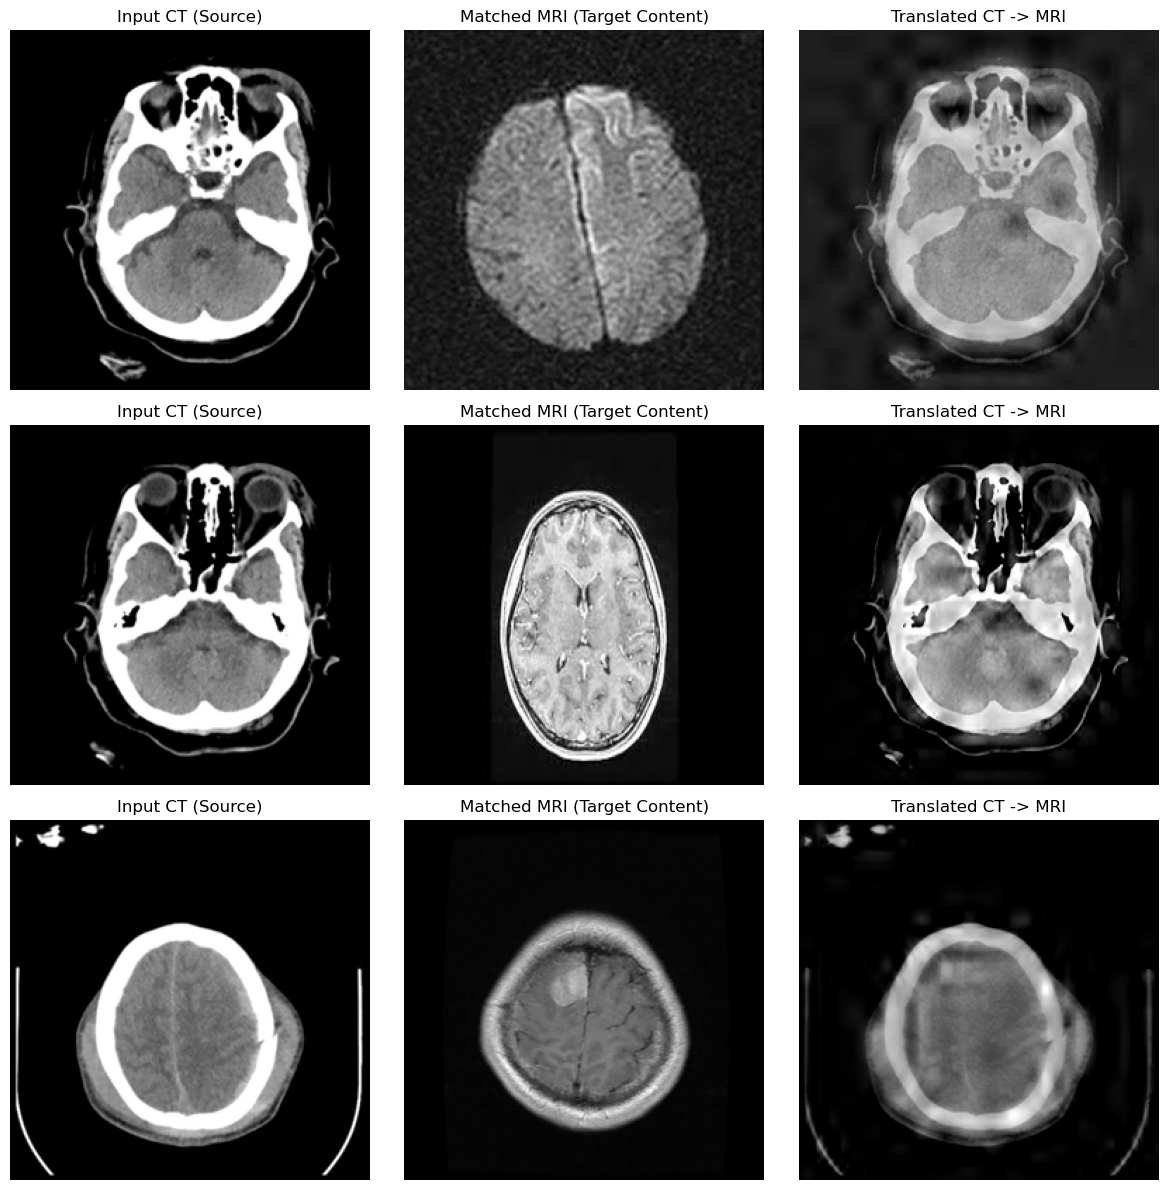

In [12]:
from sklearn.neighbors import NearestNeighbors

indices_A = [i for i, x in enumerate(df_meta['domain']) if x == 'A']
indices_B = [i for i, x in enumerate(df_meta['domain']) if x == 'B']

Z_A = Z[indices_A]
Z_B = Z[indices_B]

dummy_img = np.zeros(IMG_SIZE)
coeffs = pywt.wavedec2(dummy_img, wavelet=WAVELET_TYPE, level=LEVEL)
arr, coeff_slices = pywt.coeffs_to_array(coeffs)
coeff_shape = arr.shape 

def get_global_idx(subset_idx, domain):
    if domain == 'A': return indices_A[subset_idx]
    return indices_B[subset_idx]

# Fit Nearest Neighbor on INVARIANT (Content) subspace of Domain B
nbrs_B = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(Z_B[:, inactive_mask])

# --- 2. Histogram Matching Helper ---
def match_histograms_1d(source, template, mask_zeros=False):
    """
    Map source distribution to template distribution using Quantile Matching.
    """

    oldshape = source.shape
    source_flat = source.ravel()
    template_flat = template.ravel()
    if mask_zeros:
        # For Approximation band (Intensity), background is near 0.
        # We use a small epsilon to catch floating point 'zeros'
        eps = 1e-5
        mask_src = np.abs(source_flat) > eps
        mask_tmpl = np.abs(template_flat) > eps
    else:
        mask_src = np.ones(source_flat.shape, dtype=bool)
        mask_tmpl = np.ones(template_flat.shape, dtype=bool)
    
    if mask_src.sum() == 0 or mask_tmpl.sum() == 0:
        return source 
    
    # Extracting foreground
    s_values = source_flat[mask_src]
    t_values = template_flat[mask_tmpl]
    
    # quantile matching using onnly the foreground info
    s_indices = np.argsort(s_values)
    
    quantiles = np.linspace(0, 1, len(s_values))
    # Get values from template at these quantiles
    template_quantiles = np.interp(
        quantiles, 
        np.linspace(0, 1, len(t_values)), 
        np.sort(t_values)
    )
    
    matched = source_flat.copy()
    
    inverse_s_indices = np.argsort(s_indices)
    matched_foreground = template_quantiles[inverse_s_indices]
    
    matched[mask_src] = matched_foreground
    return matched.reshape(oldshape)

def translate_ct_to_mri(idx_A_local):
    # Match Content
    z_query = Z_A[idx_A_local]
    content_query = z_query[inactive_mask].reshape(1, -1)
    
    # Find MRI with closest anatomy
    dists, idxs = nbrs_B.kneighbors(content_query)
    idx_B_match = idxs[0][0]
    
    # Load Raw Wavelets (Dense)
    global_idx_A = get_global_idx(idx_A_local, 'A')
    global_idx_B = get_global_idx(idx_B_match, 'B')
    
    vec_A = W[global_idx_A].toarray().flatten()
    vec_B = W[global_idx_B].toarray().flatten()

    coeffs_A = vec_A.reshape(coeff_shape)
    coeffs_B = vec_B.reshape(coeff_shape)
    
    # We need to reconstruct the list-of-arrays format to access slices
    # We use a dummy rebuild to get the structure, then modify it in place
    # (Efficiency note: faster to map slices directly if we knew them perfectly, 
    # but using pywt helper is safer)
    
    list_A = pywt.array_to_coeffs(coeffs_A, coeff_slices, output_format='wavedec2')
    list_B = pywt.array_to_coeffs(coeffs_B, coeff_slices, output_format='wavedec2')
    
    # Style Transfer (Histogram Matching)
    # We create a new list for the output
    list_hybrid = []
    
    # Approximation (Low Freq / Contrast) -> Match Histograms
    # This forces CT gray levels to match MRI gray levels
    approx_hybrid = match_histograms_1d(list_A[0], list_B[0], mask_zeros=True)
    list_hybrid.append(approx_hybrid)
    
    # Details (High Freq / Texture) -> Match Histograms
    for detail_A, detail_B in zip(list_A[1:], list_B[1:]):
        # detail_A is a tuple (H, V, D)
        hybrid_detail_tuple = []
        for band_A, band_B in zip(detail_A, detail_B):
            # Force CT noise/edges to have MRI statistics
            band_hybrid = match_histograms_1d(band_A, band_B, mask_zeros=True)
            hybrid_detail_tuple.append(band_hybrid)
        list_hybrid.append(tuple(hybrid_detail_tuple))
        
    # Reconstruct and Denormalize
    # Inverse Wavelet
    recon_norm = pywt.waverec2(list_hybrid, wavelet=WAVELET_TYPE)
    
    # We matched the histograms in Z-score space.
    # Now we need to project back to pixel space.
    # Since aligned distributions, the result is in the "MRI Z-score" space.
    # So using the MRI's (Target) mu/std to denormalize.
    
    target_stats = df_meta.iloc[global_idx_B]
    mu_target = target_stats['mu']
    std_target = target_stats['std']
    
    recon = (recon_norm * std_target) + mu_target
    return np.clip(recon, 0, 255).astype('uint8'), idx_B_match

test_indices = np.random.choice(len(Z_A), 3, replace=False)

plt.figure(figsize=(12, 12))

for i, idx_A in enumerate(test_indices):
    img_fake, idx_B = translate_ct_to_mri(idx_A)
    
    # Originals
    g_idx_A = get_global_idx(idx_A, 'A')
    g_idx_B = get_global_idx(idx_B, 'B')
    # re-open to get the clean original, bypassing the z-score/wavelet pipeline)
    path_A = df_meta.iloc[g_idx_A]['path']
    path_B = df_meta.iloc[g_idx_B]['path']
    
    img_A = Image.open(path_A).convert('L').resize(IMG_SIZE)
    img_B = Image.open(path_B).convert('L').resize(IMG_SIZE)
    
    plt.subplot(3, 3, 3*i + 1)
    plt.imshow(img_A, cmap='gray')
    plt.title("Input CT (Source)")
    plt.axis('off')
    
    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(img_B, cmap='gray')
    plt.title("Matched MRI (Target Content)")
    plt.axis('off')
    
    plt.subplot(3, 3, 3*i + 3)
    plt.imshow(img_fake, cmap='gray')
    plt.title("Translated CT -> MRI")
    plt.axis('off')

plt.tight_layout()
plt.show()

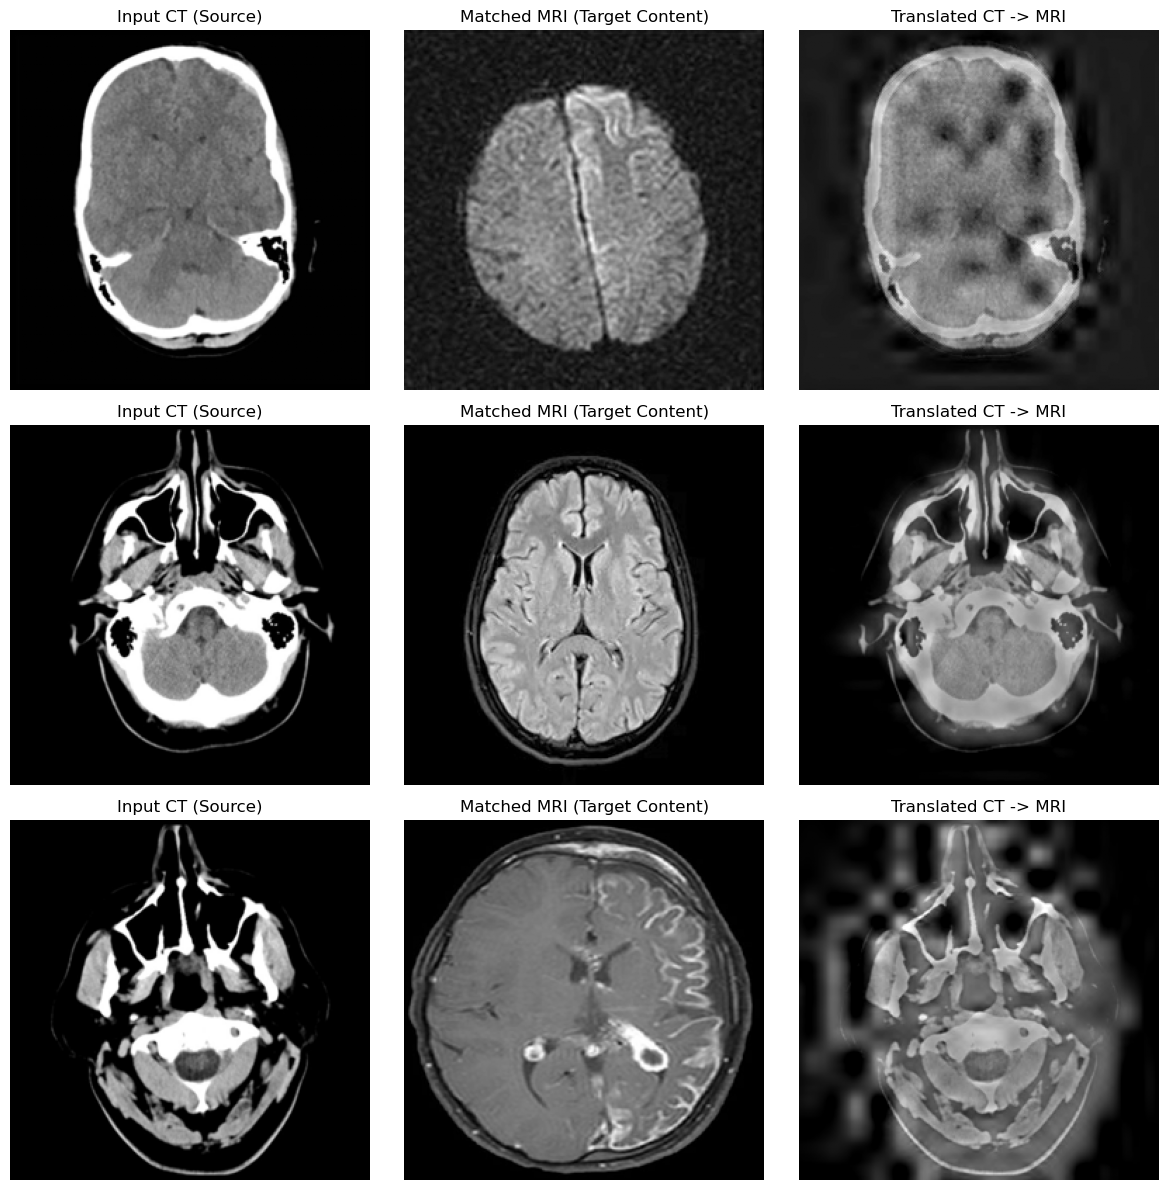

In [41]:
from sklearn.neighbors import NearestNeighbors

indices_A = [i for i, x in enumerate(df_meta['domain']) if x == 'A']
indices_B = [i for i, x in enumerate(df_meta['domain']) if x == 'B']

Z_A = Z[indices_A]
Z_B = Z[indices_B]

dummy_img = np.zeros(IMG_SIZE)
coeffs = pywt.wavedec2(dummy_img, wavelet=WAVELET_TYPE, level=LEVEL)
arr, coeff_slices = pywt.coeffs_to_array(coeffs)
coeff_shape = arr.shape 

# Fit Nearest Neighbor on INVARIANT (Content) subspace of Domain B
nbrs_B = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(Z_B[:, inactive_mask])
test_indices = np.random.choice(len(Z_A), 3, replace=False)

plt.figure(figsize=(12, 12))

for i, idx_A in enumerate(test_indices):
    img_fake, idx_B = translate_ct_to_mri(idx_A)
    
    # Originals
    g_idx_A = get_global_idx(idx_A, 'A')
    g_idx_B = get_global_idx(idx_B, 'B')
    # re-open to get the clean original, bypassing the z-score/wavelet pipeline)
    path_A = df_meta.iloc[g_idx_A]['path']
    path_B = df_meta.iloc[g_idx_B]['path']
    
    img_A = Image.open(path_A).convert('L').resize(IMG_SIZE)
    img_B = Image.open(path_B).convert('L').resize(IMG_SIZE)
    
    plt.subplot(3, 3, 3*i + 1)
    plt.imshow(img_A, cmap='gray')
    plt.title("Input CT (Source)")
    plt.axis('off')
    
    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(img_B, cmap='gray')
    plt.title("Matched MRI (Target Content)")
    plt.axis('off')
    
    plt.subplot(3, 3, 3*i + 3)
    plt.imshow(img_fake, cmap='gray')
    plt.title("Translated CT -> MRI")
    plt.axis('off')

plt.tight_layout()
plt.show()

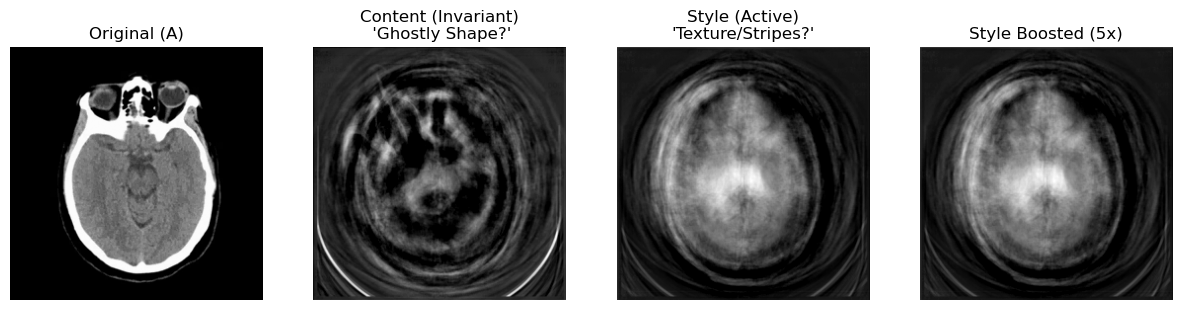

In [40]:
idx = np.random.choice(len(df_meta)) 
z_sample = Z[idx]
original_shape = IMG_SIZE

z_content = z_sample.copy()
z_content[active_mask] = 0  
# Zeroing out style (domain-variant), keep content (domain invariant)

z_style = z_sample.copy()
z_style[inactive_mask] = 0  # Zero out content, keep style

# Inverting SVD to get back to Wavelet Space
# shape: (1, n_features)
w_content = svd.inverse_transform(z_content.reshape(1, -1))
w_style = svd.inverse_transform(z_style.reshape(1, -1))

# img_content = reconstruct_image_from_vector(sparse.csr_matrix(w_content), coeff_slices, original_shape, coeff_shape)
# img_style = reconstruct_image_from_vector(sparse.csr_matrix(w_style), coeff_slices, original_shape, coeff_shape)
# img_original = reconstruct_image_from_vector(W[idx], coeff_slices, original_shape, coeff_shape)

img_content = reconstruct_image_with_denorm(sparse.csr_matrix(w_content), coeff_slices, original_shape, coeff_shape,
                                            mu_val, std_val)
img_style = reconstruct_image_with_denorm(sparse.csr_matrix(w_style), coeff_slices, original_shape, coeff_shape,
                                            mu_val, std_val)
img_original = reconstruct_image_with_denorm(W[idx], coeff_slices, original_shape, coeff_shape,
                                            mu_val, std_val)

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(img_original, cmap='gray')
plt.title(f"Original ({df_meta.iloc[idx]['domain']})")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img_content, cmap='gray')
plt.title("Content (Invariant)\n 'Ghostly Shape?'")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(img_style, cmap='gray')
plt.title("Style (Active)\n'Texture/Stripes?'")
plt.axis('off')

plt.subplot(1, 4, 4)
# Visualizing Style Enhanced (Contrast boosted)
plt.imshow(np.clip(img_style * 2.0, 0, 255).astype('uint8'), cmap='gray') 
plt.title("Style Boosted (5x)")
plt.axis('off')

plt.show()

In [29]:
idx = np.random.choice(len(df_meta)) 
z_sample = Z[idx]
original_shape = IMG_SIZE

z_content = z_sample.copy()
z_content[active_mask] = 0  
# Zeroing out style (domain-variant), keep content (domain invariant)

z_style = z_sample.copy()
z_style[inactive_mask] = 0  # Zero out content, keep style

# Inverting SVD to get back to Wavelet Space
# shape: (1, n_features)
w_content = svd.inverse_transform(z_content.reshape(1, -1))
w_style = svd.inverse_transform(z_style.reshape(1, -1))

# img_content = reconstruct_image_from_vector(sparse.csr_matrix(w_content), coeff_slices, original_shape, coeff_shape)
# img_style = reconstruct_image_from_vector(sparse.csr_matrix(w_style), coeff_slices, original_shape, coeff_shape)
# img_original = reconstruct_image_from_vector(W[idx], coeff_slices, original_shape, coeff_shape)

img_content = reconstruct_image_with_denorm(sparse.csr_matrix(w_content), coeff_slices, original_shape, coeff_shape,
                                            mu_val, std_val)
img_style = reconstruct_image_with_denorm(sparse.csr_matrix(w_style), coeff_slices, original_shape, coeff_shape,
                                            mu_val, std_val)
img_original = reconstruct_image_with_denorm(W[idx], coeff_slices, original_shape, coeff_shape,
                                            mu_val, std_val)

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(img_original, cmap='gray')
plt.title(f"Original ({df_meta.iloc[idx]['domain']})")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img_content, cmap='gray')
plt.title("Content (Invariant)\n 'Ghostly Shape?'")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(img_style, cmap='gray')
plt.title("Style (Active)\n'Texture/Stripes?'")
plt.axis('off')

plt.subplot(1, 4, 4)
# Visualizing Style Enhanced (Contrast boosted)
plt.imshow(np.clip(img_style * 2.0, 0, 255).astype('uint8'), cmap='gray') 
plt.title("Style Boosted (2x)")
plt.axis('off')

plt.show()

### Abalation 

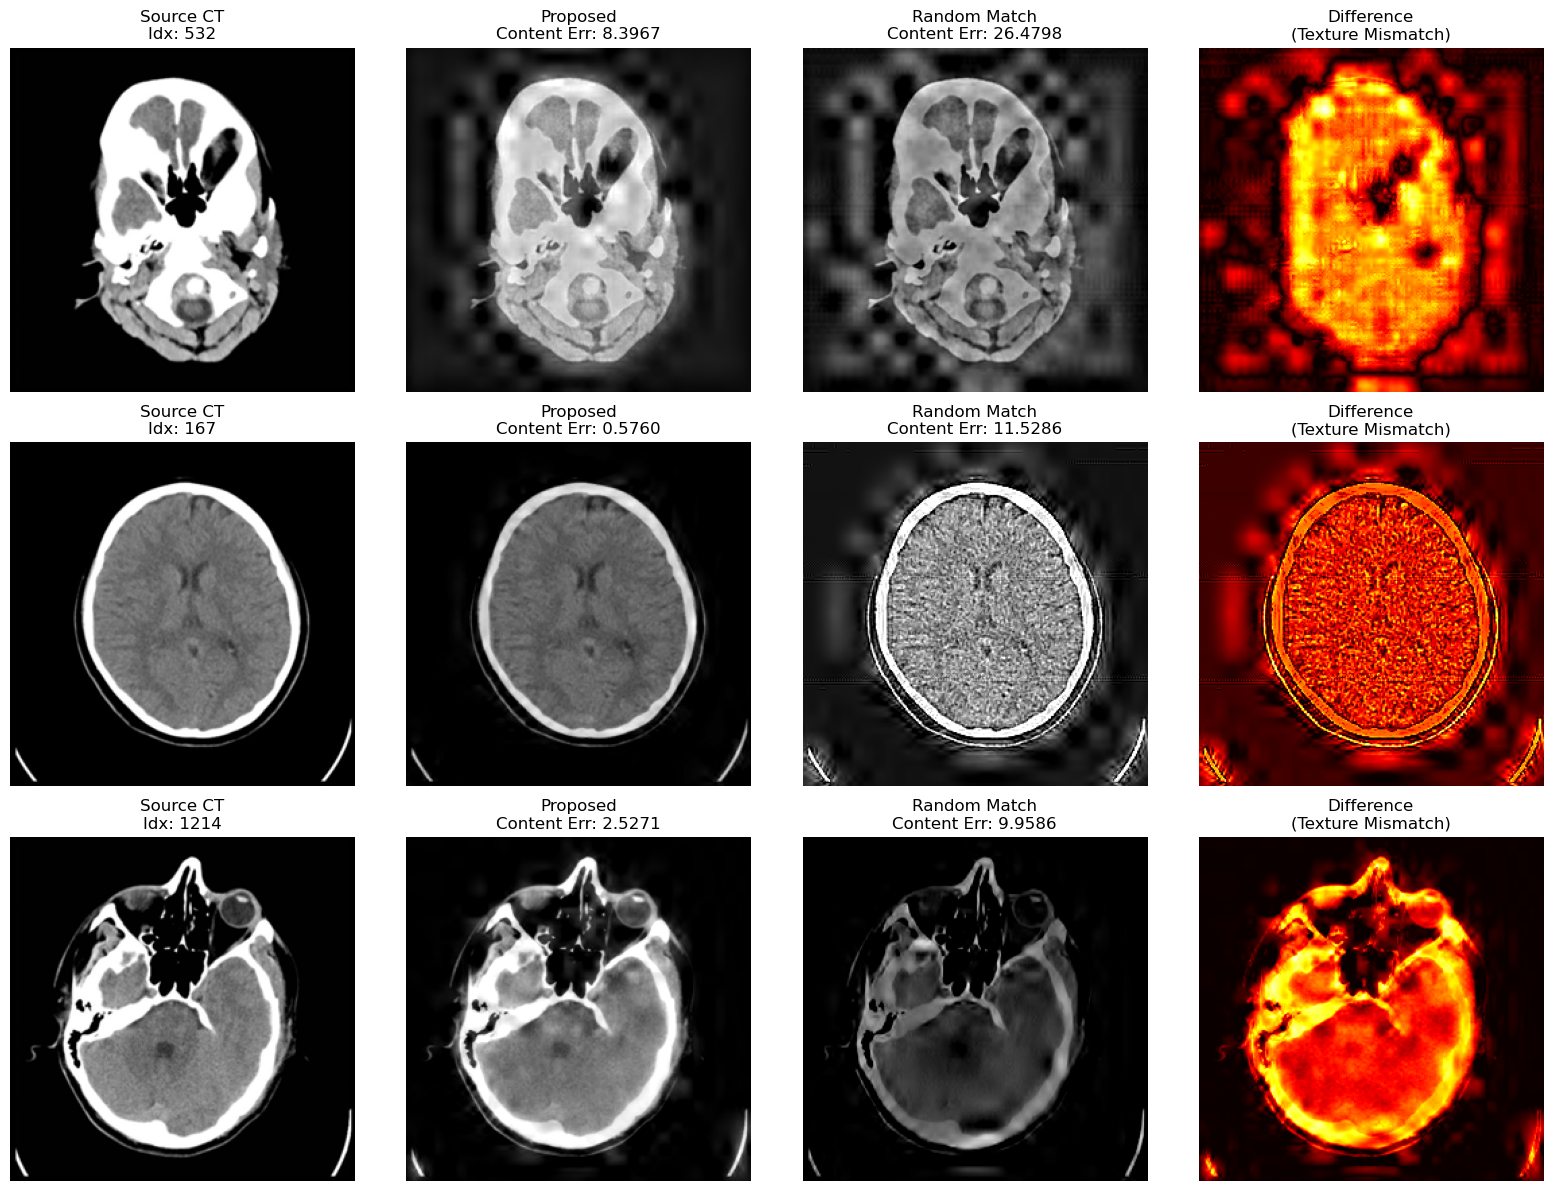

Mean Content Error (Proposed): 3.8333
Mean Content Error (Random):   15.9890


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pywt
from scipy import sparse

dummy_img = np.zeros(IMG_SIZE)
coeffs = pywt.wavedec2(dummy_img, wavelet=WAVELET_TYPE, level=LEVEL)
arr, coeff_slices = pywt.coeffs_to_array(coeffs)
coeff_shape = arr.shape 

def translate_ct_to_mri_random(idx_A_local):
    idx_B_random = np.random.choice(len(Z_B))
    global_idx_A = get_global_idx(idx_A_local, 'A')
    global_idx_B = get_global_idx(idx_B_random, 'B') # Using Random B
    
    vec_A = W[global_idx_A].toarray().flatten()
    vec_B = W[global_idx_B].toarray().flatten()
    
    coeffs_A = vec_A.reshape(coeff_shape)
    coeffs_B = vec_B.reshape(coeff_shape)
    
    list_A = pywt.array_to_coeffs(coeffs_A, coeff_slices, output_format='wavedec2')
    list_B = pywt.array_to_coeffs(coeffs_B, coeff_slices, output_format='wavedec2')

    list_hybrid = []
    approx_hybrid = match_histograms_1d(list_A[0], list_B[0], mask_zeros=True)
    list_hybrid.append(approx_hybrid)

    for detail_A, detail_B in zip(list_A[1:], list_B[1:]):
        hybrid_detail_tuple = []
        for band_A, band_B in zip(detail_A, detail_B):
            band_hybrid = match_histograms_1d(band_A, band_B, mask_zeros=False)
            hybrid_detail_tuple.append(band_hybrid)
        list_hybrid.append(tuple(hybrid_detail_tuple))

    recon_norm = pywt.waverec2(list_hybrid, wavelet=WAVELET_TYPE)

    target_stats = df_meta.iloc[global_idx_B]
    mu_target = target_stats['mu']
    std_target = target_stats['std']
    
    recon = (recon_norm * std_target) + mu_target
    return np.clip(recon, 0, 255).astype('uint8'), idx_B_random

def calculate_content_error(img_generated, z_source_content):
    """
    Project generated image back to Z space and measure distance 
    to original source in the INVARIANT subspace.
    """
    # Project Image -> Wavelet -> Sparse Vector
    img_arr = np.array(Image.fromarray(img_generated).resize(IMG_SIZE).convert('L'))
    
    # normalize using the same stats logic? 
    # SVD expects z-scored inputs?
    mu, std = img_arr.mean(), img_arr.std() + 1e-8
    img_norm = (img_arr - mu) / std
    
    coeffs = pywt.wavedec2(img_norm, wavelet=WAVELET_TYPE, level=LEVEL)
    coeff_arr, _ = pywt.coeffs_to_array(coeffs)
    flat = coeff_arr.reshape(-1)
    
    # Thresholding 
    k = int(np.floor((1 - KEEP_RATIO) * flat.size))
    thresh = np.partition(np.abs(flat), k)[k]
    flat[np.abs(flat) <= thresh] = 0.0
    
    vec_sparse = sparse.csr_matrix(flat)
    z_new = svd.transform(vec_sparse)
    z_new_content = z_new[:, inactive_mask]

    mse = np.mean((z_new_content - z_source_content)**2)
    return mse

test_indices = np.random.choice(len(Z_A), 3, replace=False)
fig, axes = plt.subplots(len(test_indices), 4, figsize=(16, 4 * len(test_indices)))
if len(test_indices) == 1: axes = [axes]

cols = ["Source CT", "Proposed (Causal Match)", "Random Match (Ablation)", "Difference (Proposed vs Random)"]

errors_proposed = []
errors_random = []

for i, idx_A in enumerate(test_indices):
    img_proposed, idx_B_prop = translate_ct_to_mri(idx_A) # Your working function
    img_random, idx_B_rand = translate_ct_to_mri_random(idx_A)
    
    g_idx_A = get_global_idx(idx_A, 'A')
    img_A = Image.open(df_meta.iloc[g_idx_A]['path']).convert('L').resize(IMG_SIZE)
    z_src_content = Z_A[idx_A][inactive_mask].reshape(1, -1)
    
    err_p = calculate_content_error(img_proposed, z_src_content)
    err_r = calculate_content_error(img_random, z_src_content)
    
    errors_proposed.append(err_p)
    errors_random.append(err_r)
    
    axes[i][0].imshow(img_A, cmap='gray')
    axes[i][0].set_title(f"Source CT\nIdx: {idx_A}")
    
    axes[i][1].imshow(img_proposed, cmap='gray')
    axes[i][1].set_title(f"Proposed\nContent Err: {err_p:.4f}")
    
    axes[i][2].imshow(img_random, cmap='gray')
    axes[i][2].set_title(f"Random Match\nContent Err: {err_r:.4f}")
    
    # Difference Map 
    diff = np.abs(img_proposed.astype(float) - img_random.astype(float))
    axes[i][3].imshow(diff, cmap='hot')
    axes[i][3].set_title(f"Difference\n(Texture Mismatch)")

    for ax in axes[i]: ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Mean Content Error (Proposed): {np.mean(errors_proposed):.4f}")
print(f"Mean Content Error (Random):   {np.mean(errors_random):.4f}")

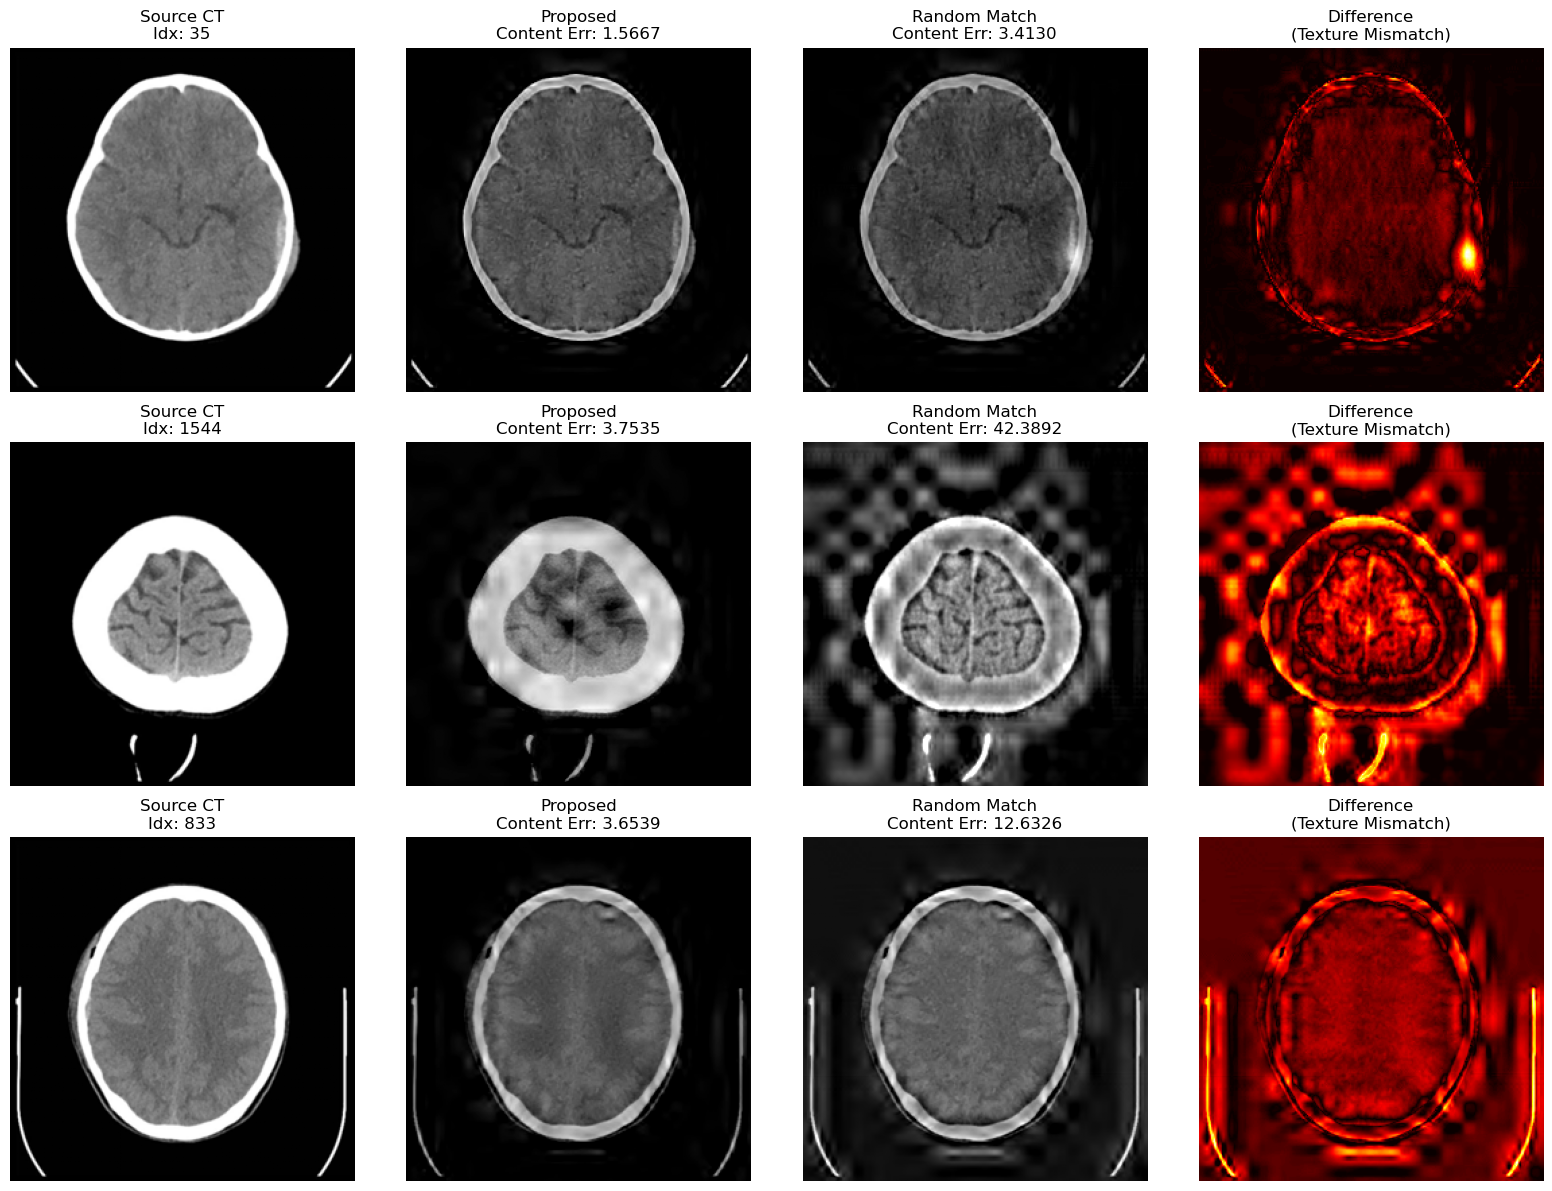

Mean Content Error (Proposed): 2.9914
Mean Content Error (Random):   19.4783


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pywt
from scipy import sparse

dummy_img = np.zeros(IMG_SIZE)
coeffs = pywt.wavedec2(dummy_img, wavelet=WAVELET_TYPE, level=LEVEL)
arr, coeff_slices = pywt.coeffs_to_array(coeffs)
coeff_shape = arr.shape 

def translate_ct_to_mri_random(idx_A_local):
    idx_B_random = np.random.choice(len(Z_B))
    global_idx_A = get_global_idx(idx_A_local, 'A')
    global_idx_B = get_global_idx(idx_B_random, 'B') # Using Random B
    
    vec_A = W[global_idx_A].toarray().flatten()
    vec_B = W[global_idx_B].toarray().flatten()
    
    coeffs_A = vec_A.reshape(coeff_shape)
    coeffs_B = vec_B.reshape(coeff_shape)
    
    list_A = pywt.array_to_coeffs(coeffs_A, coeff_slices, output_format='wavedec2')
    list_B = pywt.array_to_coeffs(coeffs_B, coeff_slices, output_format='wavedec2')

    list_hybrid = []
    approx_hybrid = match_histograms_1d(list_A[0], list_B[0], mask_zeros=True)
    list_hybrid.append(approx_hybrid)

    for detail_A, detail_B in zip(list_A[1:], list_B[1:]):
        hybrid_detail_tuple = []
        for band_A, band_B in zip(detail_A, detail_B):
            band_hybrid = match_histograms_1d(band_A, band_B, mask_zeros=False)
            hybrid_detail_tuple.append(band_hybrid)
        list_hybrid.append(tuple(hybrid_detail_tuple))

    recon_norm = pywt.waverec2(list_hybrid, wavelet=WAVELET_TYPE)

    target_stats = df_meta.iloc[global_idx_B]
    mu_target = target_stats['mu']
    std_target = target_stats['std']
    
    recon = (recon_norm * std_target) + mu_target
    return np.clip(recon, 0, 255).astype('uint8'), idx_B_random

def calculate_content_error(img_generated, z_source_content):
    """
    Project generated image back to Z space and measure distance 
    to original source in the INVARIANT subspace.
    """
    # Project Image -> Wavelet -> Sparse Vector
    img_arr = np.array(Image.fromarray(img_generated).resize(IMG_SIZE).convert('L'))
    
    # normalize using the same stats logic? 
    # SVD expects z-scored inputs?
    mu, std = img_arr.mean(), img_arr.std() + 1e-8
    img_norm = (img_arr - mu) / std
    
    coeffs = pywt.wavedec2(img_norm, wavelet=WAVELET_TYPE, level=LEVEL)
    coeff_arr, _ = pywt.coeffs_to_array(coeffs)
    flat = coeff_arr.reshape(-1)
    
    # Thresholding 
    k = int(np.floor((1 - KEEP_RATIO) * flat.size))
    thresh = np.partition(np.abs(flat), k)[k]
    flat[np.abs(flat) <= thresh] = 0.0
    
    vec_sparse = sparse.csr_matrix(flat)
    z_new = svd.transform(vec_sparse)
    z_new_content = z_new[:, inactive_mask]

    mse = np.mean((z_new_content - z_source_content)**2)
    return mse

test_indices = np.random.choice(len(Z_A), 3, replace=False)
fig, axes = plt.subplots(len(test_indices), 4, figsize=(16, 4 * len(test_indices)))
if len(test_indices) == 1: axes = [axes]

cols = ["Source CT", "Proposed (Causal Match)", "Random Match (Ablation)", "Difference (Proposed vs Random)"]

errors_proposed = []
errors_random = []

for i, idx_A in enumerate(test_indices):
    img_proposed, idx_B_prop = translate_ct_to_mri(idx_A) # Your working function
    img_random, idx_B_rand = translate_ct_to_mri_random(idx_A)
    
    g_idx_A = get_global_idx(idx_A, 'A')
    img_A = Image.open(df_meta.iloc[g_idx_A]['path']).convert('L').resize(IMG_SIZE)
    z_src_content = Z_A[idx_A][inactive_mask].reshape(1, -1)
    
    err_p = calculate_content_error(img_proposed, z_src_content)
    err_r = calculate_content_error(img_random, z_src_content)
    
    errors_proposed.append(err_p)
    errors_random.append(err_r)
    
    axes[i][0].imshow(img_A, cmap='gray')
    axes[i][0].set_title(f"Source CT\nIdx: {idx_A}")
    
    axes[i][1].imshow(img_proposed, cmap='gray')
    axes[i][1].set_title(f"Proposed\nContent Err: {err_p:.4f}")
    
    axes[i][2].imshow(img_random, cmap='gray')
    axes[i][2].set_title(f"Random Match\nContent Err: {err_r:.4f}")
    
    # Difference Map 
    diff = np.abs(img_proposed.astype(float) - img_random.astype(float))
    axes[i][3].imshow(diff, cmap='hot')
    axes[i][3].set_title(f"Difference\n(Texture Mismatch)")

    for ax in axes[i]: ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Mean Content Error (Proposed): {np.mean(errors_proposed):.4f}")
print(f"Mean Content Error (Random):   {np.mean(errors_random):.4f}")

In [2]:
import torch

ImportError: libprotobuf.so.29.3.0: cannot open shared object file: No such file or directory

In [ ]:

# --- Configuration ---
NUM_SAMPLES = 500  # Number of images to evaluate (Standard is 2048, but 500 is good for a check)
BATCH_SIZE = 32    # Process in chunks to save RAM
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Preprocessing for Inception V3 ---
# Inception expects (3, 299, 299). 
# We need to repeat our Grayscale channel 3 times to mimic RGB.
preprocess = T.Compose([
    T.Resize((299, 299)),
    T.ToTensor(),          # Converts [0, 255] -> [0.0, 1.0]
    T.Lambda(lambda x: x.repeat(3, 1, 1)) # Repeat 1 channel to 3 channels
])

def get_real_mri_batch(indices):
    """Loads real MRI images from disk."""
    images = []
    for idx in indices:
        # Get path from metadata
        # Recall: df_meta indices are global. We need to map subset index -> global.
        global_idx = get_global_idx(idx, 'B')
        path = df_meta.iloc[global_idx]['path']
        
        # Load, convert to L (Grayscale), apply transforms
        img = Image.open(path).convert('L')
        img_t = preprocess(img)
        images.append(img_t)
        
    return torch.stack(images).to(DEVICE)

def get_fake_mri_batch(indices):
    """Generates translated images using your pipeline."""
    images = []
    for idx_A in indices:
        # 1. Generate using your function
        # img_fake is a numpy array (H, W) uint8
        img_fake_np, _ = translate_ct_to_mri(idx_A) 
        
        # 2. Convert to PIL -> Tensor
        img_pil = Image.fromarray(img_fake_np)
        img_t = preprocess(img_pil)
        images.append(img_t)
        
    return torch.stack(images).to(DEVICE)

# --- Main FID Loop ---

print(f"Initializing FID Metric on {DEVICE}...")
fid = FrechetInceptionDistance(feature=64).to(DEVICE) 
# feature=64 is faster/lighter. Use feature=2048 for "Academic Standard" FID.

# 1. Setup Indices
# We randomly select samples from A (CT) to translate
indices_A = np.random.choice(len(Z_A), min(NUM_SAMPLES, len(Z_A)), replace=False)
# We randomly select samples from B (MRI) to act as ground truth distribution
indices_B = np.random.choice(len(Z_B), min(NUM_SAMPLES, len(Z_B)), replace=False)

# 2. Feed Data in Batches
print(f"Computing FID with {len(indices_A)} samples...")

# Update with REAL images
for i in tqdm(range(0, len(indices_B), BATCH_SIZE), desc="Processing Real MRIs"):
    batch_indices = indices_B[i : i + BATCH_SIZE]
    real_batch = get_real_mri_batch(batch_indices)
    
    # real=True means these are the Target distribution
    # We must convert back to uint8 [0, 255] for torchmetrics usually, 
    # but check doc: torchmetrics accepts float [0,1] or byte [0,255].
    # It handles [0,1] floats automatically.
    fid.update(real_batch, real=True)

# Update with FAKE images
for i in tqdm(range(0, len(indices_A), BATCH_SIZE), desc="Processing Fake MRIs"):
    batch_indices = indices_A[i : i + BATCH_SIZE]
    fake_batch = get_fake_mri_batch(batch_indices)
    
    # real=False means these are the Generated distribution
    fid.update(fake_batch, real=False)

# 3. Calculate
print("Finalizing calculation...")
fid_score = fid.compute()
print(f"==================================")
print(f"FID Score: {fid_score.item():.4f}")
print(f"==================================")

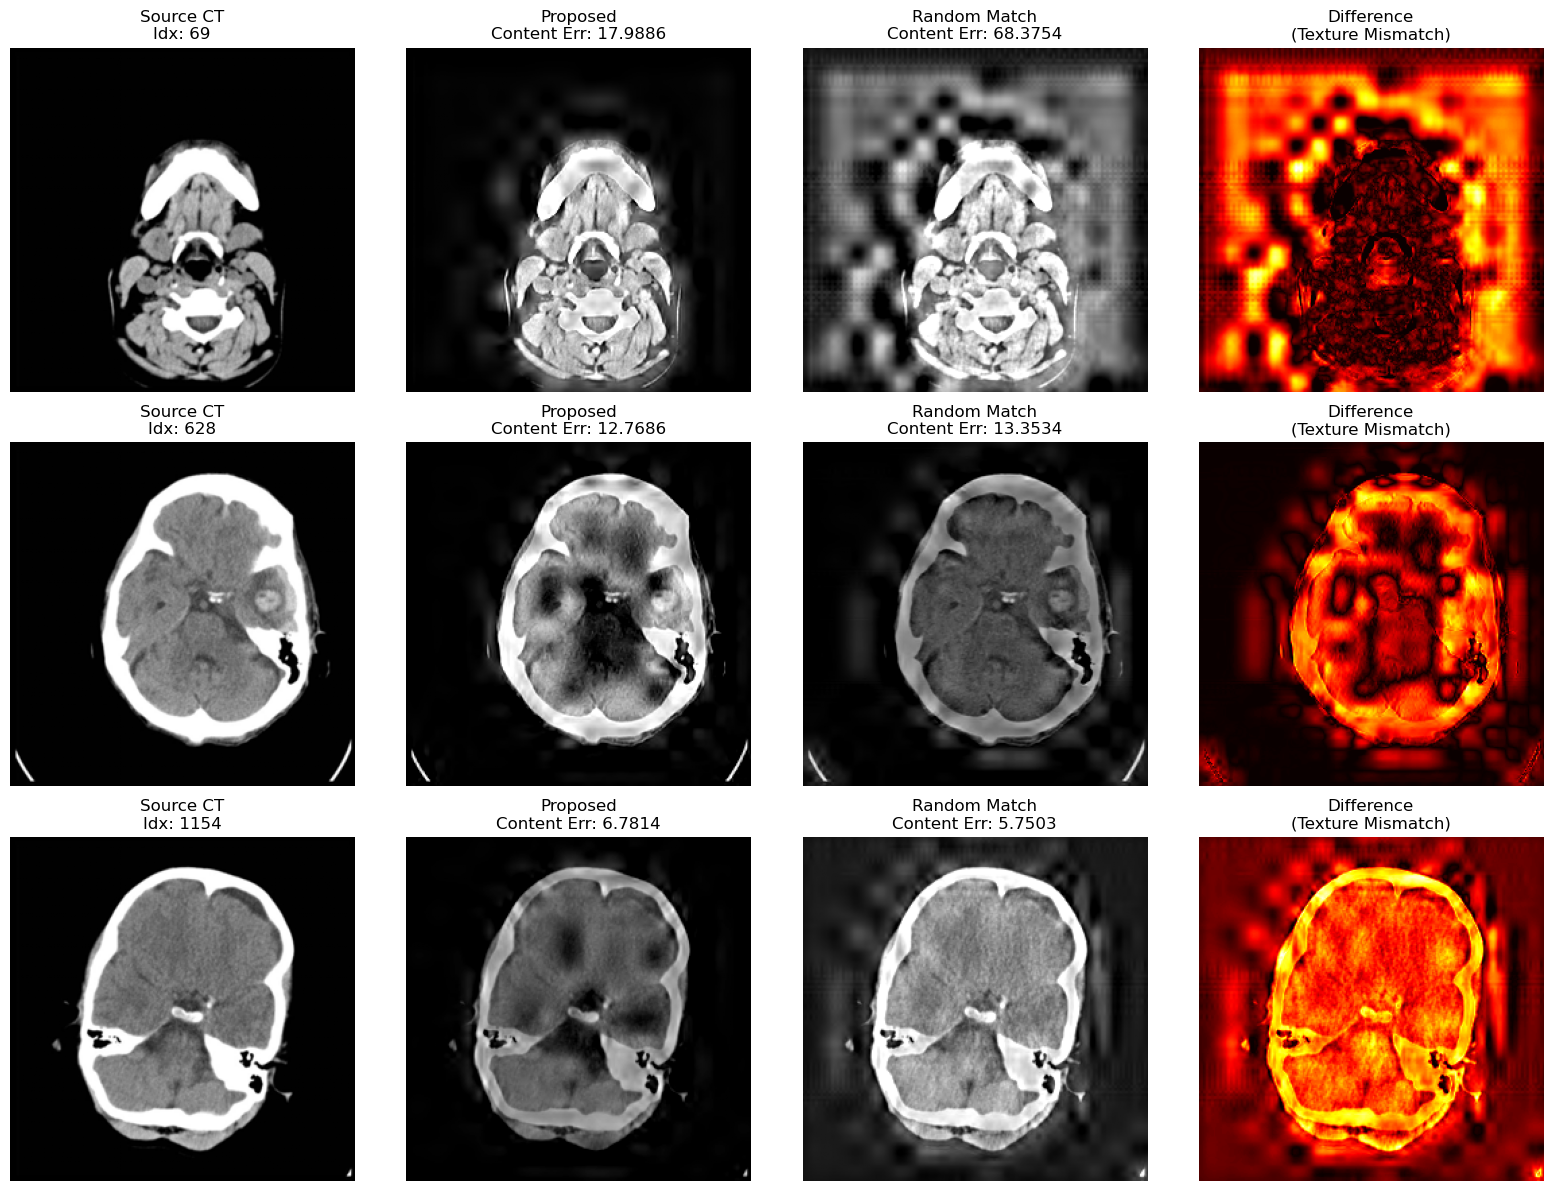

Mean Content Error (Proposed): 12.5128
Mean Content Error (Random):   29.1597


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pywt
from scipy import sparse

dummy_img = np.zeros(IMG_SIZE)
coeffs = pywt.wavedec2(dummy_img, wavelet=WAVELET_TYPE, level=LEVEL)
arr, coeff_slices = pywt.coeffs_to_array(coeffs)
coeff_shape = arr.shape 

def translate_ct_to_mri_random(idx_A_local):
    idx_B_random = np.random.choice(len(Z_B))
    global_idx_A = get_global_idx(idx_A_local, 'A')
    global_idx_B = get_global_idx(idx_B_random, 'B') # Using Random B
    
    vec_A = W[global_idx_A].toarray().flatten()
    vec_B = W[global_idx_B].toarray().flatten()
    
    coeffs_A = vec_A.reshape(coeff_shape)
    coeffs_B = vec_B.reshape(coeff_shape)
    
    list_A = pywt.array_to_coeffs(coeffs_A, coeff_slices, output_format='wavedec2')
    list_B = pywt.array_to_coeffs(coeffs_B, coeff_slices, output_format='wavedec2')

    list_hybrid = []
    approx_hybrid = match_histograms_1d(list_A[0], list_B[0], mask_zeros=True)
    list_hybrid.append(approx_hybrid)

    for detail_A, detail_B in zip(list_A[1:], list_B[1:]):
        hybrid_detail_tuple = []
        for band_A, band_B in zip(detail_A, detail_B):
            band_hybrid = match_histograms_1d(band_A, band_B, mask_zeros=False)
            hybrid_detail_tuple.append(band_hybrid)
        list_hybrid.append(tuple(hybrid_detail_tuple))

    recon_norm = pywt.waverec2(list_hybrid, wavelet=WAVELET_TYPE)

    target_stats = df_meta.iloc[global_idx_B]
    mu_target = target_stats['mu']
    std_target = target_stats['std']
    
    recon = (recon_norm * std_target) + mu_target
    return np.clip(recon, 0, 255).astype('uint8'), idx_B_random

def calculate_content_error(img_generated, z_source_content):
    """
    Project generated image back to Z space and measure distance 
    to original source in the INVARIANT subspace.
    """
    # Project Image -> Wavelet -> Sparse Vector
    img_arr = np.array(Image.fromarray(img_generated).resize(IMG_SIZE).convert('L'))
    
    # normalize using the same stats logic? 
    # SVD expects z-scored inputs?
    mu, std = img_arr.mean(), img_arr.std() + 1e-8
    img_norm = (img_arr - mu) / std
    
    coeffs = pywt.wavedec2(img_norm, wavelet=WAVELET_TYPE, level=LEVEL)
    coeff_arr, _ = pywt.coeffs_to_array(coeffs)
    flat = coeff_arr.reshape(-1)
    
    # Thresholding 
    k = int(np.floor((1 - KEEP_RATIO) * flat.size))
    thresh = np.partition(np.abs(flat), k)[k]
    flat[np.abs(flat) <= thresh] = 0.0
    
    vec_sparse = sparse.csr_matrix(flat)
    z_new = svd.transform(vec_sparse)
    z_new_content = z_new[:, inactive_mask]

    mse = np.mean((z_new_content - z_source_content)**2)
    return mse

test_indices = np.random.choice(len(Z_A), 3, replace=False)
fig, axes = plt.subplots(len(test_indices), 4, figsize=(16, 4 * len(test_indices)))
if len(test_indices) == 1: axes = [axes]

cols = ["Source CT", "Proposed (Causal Match)", "Random Match (Ablation)", "Difference (Proposed vs Random)"]

errors_proposed = []
errors_random = []

for i, idx_A in enumerate(test_indices):
    img_proposed, idx_B_prop = translate_ct_to_mri(idx_A) # Your working function
    img_random, idx_B_rand = translate_ct_to_mri_random(idx_A)
    
    g_idx_A = get_global_idx(idx_A, 'A')
    img_A = Image.open(df_meta.iloc[g_idx_A]['path']).convert('L').resize(IMG_SIZE)
    z_src_content = Z_A[idx_A][inactive_mask].reshape(1, -1)
    
    err_p = calculate_content_error(img_proposed, z_src_content)
    err_r = calculate_content_error(img_random, z_src_content)
    
    errors_proposed.append(err_p)
    errors_random.append(err_r)
    
    axes[i][0].imshow(img_A, cmap='gray')
    axes[i][0].set_title(f"Source CT\nIdx: {idx_A}")
    
    axes[i][1].imshow(img_proposed, cmap='gray')
    axes[i][1].set_title(f"Proposed\nContent Err: {err_p:.4f}")
    
    axes[i][2].imshow(img_random, cmap='gray')
    axes[i][2].set_title(f"Random Match\nContent Err: {err_r:.4f}")
    
    # Difference Map 
    diff = np.abs(img_proposed.astype(float) - img_random.astype(float))
    axes[i][3].imshow(diff, cmap='hot')
    axes[i][3].set_title(f"Difference\n(Texture Mismatch)")

    for ax in axes[i]: ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Mean Content Error (Proposed): {np.mean(errors_proposed):.4f}")
print(f"Mean Content Error (Random):   {np.mean(errors_random):.4f}")

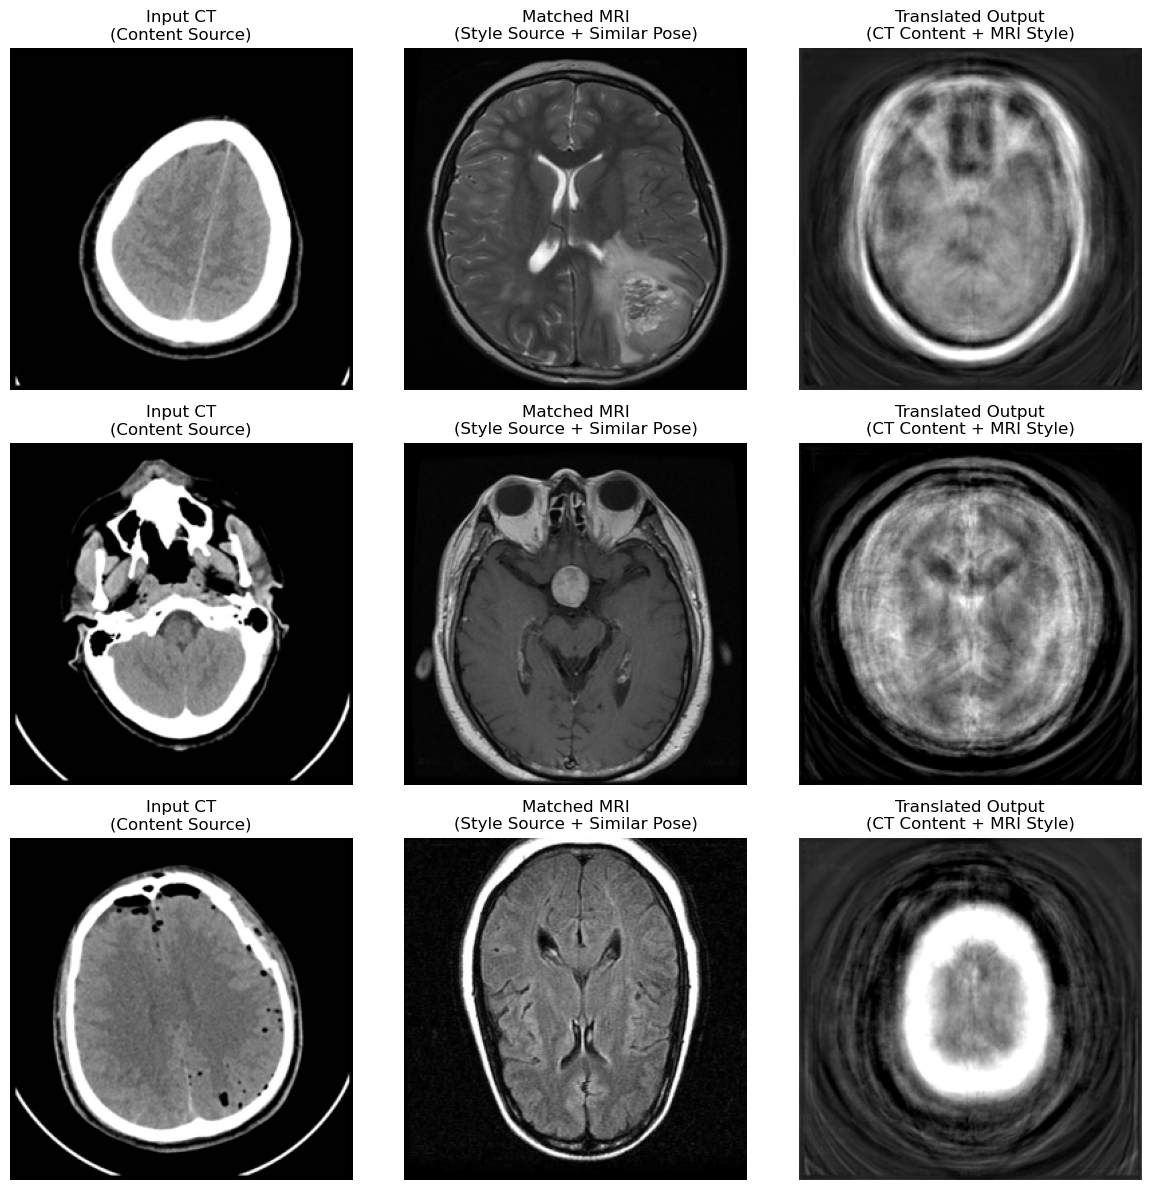

In [ ]:
from sklearn.neighbors import NearestNeighbors

# separate the latent vectors Z by domain
indices_A = [i for i, x in enumerate(df_meta['domain']) if x == 'A']
indices_B = [i for i, x in enumerate(df_meta['domain']) if x == 'B']

Z_A = Z[indices_A]
Z_B = Z[indices_B]

def get_global_idx(subset_idx, domain):
    if domain == 'A': return indices_A[subset_idx]
    else: return indices_B[subset_idx]

# We match based ONLY on the Inactive (Content) dimensions.
# We want to find a MRI (B) that has the same pose as the query CT (A).

# Filter Z_B to keep only content dimensions
Z_B_content = Z_B[:, inactive_mask]

# Fit Nearest Neighbor model on Domain B's content
nbrs_B = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(Z_B_content)

def translate_A_to_B(idx_A_local, mu, std):
    # Get the A Latent
    z_CT = Z_A[idx_A_local]
    
    # Extract B Content
    content_query = z_CT[inactive_mask].reshape(1, -1)
    
    # Find the closest MRI (Match on Content)
    distances, indices = nbrs_B.kneighbors(content_query)
    idx_B_match = indices[0][0]
    z_MRI_match = Z_B[idx_B_match]
    
    # Synthesis
    # Start with zeros
    z_hybrid = np.zeros_like(z_CT)
    
    # Add CT Content (Pose)
    z_hybrid[inactive_mask] = z_CT[inactive_mask]
    
    # Add MRI Style (Texture)
    z_hybrid[active_mask] = z_MRI_match[active_mask]
    
    # Invert SVD
    w_hybrid = svd.inverse_transform(z_hybrid.reshape(1, -1))
    
    # Invert Wavelet 
    # img_translated = reconstruct_image_from_vector(
    #     sparse.csr_matrix(w_hybrid), coeff_slices, IMG_SIZE, coeff_shape
    # )
    img_translated = reconstruct_image_with_denorm(
        sparse.csr_matrix(w_hybrid), coeff_slices, IMG_SIZE, coeff_shape,
            mu, std, wavelet=WAVELET_TYPE)
    return img_translated, idx_B_match

# Picking random CTs to translate
test_indices = np.random.choice(len(Z_A), 3, replace=False)

plt.figure(figsize=(12, 12))

for i, idx_A in enumerate(test_indices):
    # Run Translation
    target_stats = df_meta.iloc[idx_A]
    mu = target_stats['mu']
    std = target_stats['std']
    img_fake_MRI, idx_B = translate_A_to_B(idx_A, mu, std)
    
    # Get Originals for Comparison
    global_idx_A = get_global_idx(idx_A, 'A')
    global_idx_B = get_global_idx(idx_B, 'B')
    
    img_real_CT = Image.open(df_meta.iloc[global_idx_A]['path']).convert('RGB').resize(IMG_SIZE)
    img_real_MRI_match = Image.open(df_meta.iloc[global_idx_B]['path']).convert('RGB').resize(IMG_SIZE)
    
    # Plotting
    # Column 1: Input CT
    plt.subplot(3, 3, 3*i + 1)
    plt.imshow(img_real_CT, cmap = 'gray')
    plt.title(f"Input CT\n(Content Source)")
    plt.axis('off')
    
    # Column 2: Matched MRI
    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(img_real_MRI_match, cmap = 'gray')
    plt.title(f"Matched MRI\n(Style Source + Similar Pose)")
    plt.axis('off')
    
    # Column 3: Result
    plt.subplot(3, 3, 3*i + 3)
    plt.imshow(img_fake_MRI, cmap = 'gray')
    plt.title(f"Translated Output\n(CT Content + MRI Style)")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [22]:
def translate_A_to_B_statistical(idx_A_local):
    # --- 1. Matching ---
    z_horse = Z_A[idx_A_local]
    content_query = z_horse[inactive_mask].reshape(1, -1)
    
    # Find the zebra that has the same POSE
    distances, indices = nbrs_B.kneighbors(content_query)
    idx_B_match = indices[0][0]
    
    # --- 2. Load the Raw Wavelet Coefficients ---
    global_idx_A = get_global_idx(idx_A_local, 'A')
    global_idx_B = get_global_idx(idx_B_match, 'B')
    
    vec_A = W[global_idx_A].toarray().flatten()
    vec_B = W[global_idx_B].toarray().flatten()
    
    # --- 3. Perform Statistical Transfer per Channel ---
    n_coeffs = len(vec_A) // 3
    vec_hybrid = np.zeros_like(vec_A)
    
    for i in range(3): # R, G, B
        start = i * n_coeffs
        end = start + n_coeffs
        
        # Get the channel coefficients
        coeffs_A = vec_A[start:end]
        coeffs_B = vec_B[start:end]
        
        # Reshape to 2D (Wavelet Domain)
        cA_map = coeffs_A.reshape(coeff_shape)
        cB_map = coeffs_B.reshape(coeff_shape)
        
        # Initialize Hybrid Map with Horse Content
        cHybrid_map = cA_map.copy()
        
        # --- THE FIX: Iterate through dictionary values for slices ---
        # coeff_slices[0] is the Approximation (Keep as is)
        
        # Iterate over Detail Levels (1 to end)
        for s_detail in coeff_slices[1:]:
            # s_detail is a Dictionary {'da': slice, 'ad': slice, 'dd': slice}
            # We must iterate over these keys (Horizontal, Vertical, Diagonal)
            for orient_key, sl in s_detail.items():
                
                # Extract subband
                det_A = cA_map[sl]
                det_B = cB_map[sl]
                
                # Compute Stats
                mu_A, std_A = np.mean(det_A), np.std(det_A) + 1e-6
                mu_B, std_B = np.mean(det_B), np.std(det_B) + 1e-6
                
                # AdaIN Transfer
                det_hybrid = ((det_A - mu_A) / std_A) * std_B + mu_B
                
                # Place back into the specific slice
                cHybrid_map[sl] = det_hybrid
            
        # Store in the flat vector
        vec_hybrid[start:end] = cHybrid_map.flatten()

    # --- 4. Reconstruct ---
    sparse_hybrid = sparse.csr_matrix(vec_hybrid)
    
    img_translated = reconstruct_image_from_vector(
        sparse_hybrid, coeff_slices, IMG_SIZE, coeff_shape
    )
    
    return img_translated, idx_B_match